In [ ]:
category = "TF"

# Set up and Read in Data

In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 3.8 MB 29.8 MB/s 
     |████████████████████████████████| 596 kB 51.3 MB/s 
     |████████████████████████████████| 6.5 MB 48.7 MB/s 
     |████████████████████████████████| 67 kB 6.9 MB/s 
     |████████████████████████████████| 895 kB 73.7 MB/s 


In [ ]:
# watermark is a package just to see the versions of the different packages.
!pip install -q -U watermark

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.3 which is incompatible.


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

numpy       : 1.21.5
pandas      : 1.3.5
torch       : 1.10.0+cu111
transformers: 4.17.0



In [ ]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from sklearn.metrics import accuracy_score

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#DATA_FILE_PATH = 'drive/MyDrive/4B Projects/MSCI 598 (Deep Learning for NLP) Project/Code'
DATA_FILE_PATH = 'drive/MyDrive/Project'

df_train = pd.read_csv(DATA_FILE_PATH+"/train.csv")
df_val = pd.read_csv(DATA_FILE_PATH+"/val.csv")
df_test = pd.read_csv(DATA_FILE_PATH+"/test.csv")

In [ ]:
# Print number in each group.
print("Training: ", len(df_train))
print("Val: ", len(df_val))
print("Test: ", len(df_test))

Training:  50971
Val:  6471
Test:  4621


In [ ]:
# To get reproducible results.
from numpy.random import seed
seed(598)

# Data Preprocessing

In [ ]:
# Convert all values in text column to string.
df_train["text"] = df_train["text"].apply(lambda x: str(x))
df_val["text"] = df_val["text"].apply(lambda x: str(x))
df_test["text"] = df_test["text"].apply(lambda x: str(x))

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
token_lens = []

for txt in df_train.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


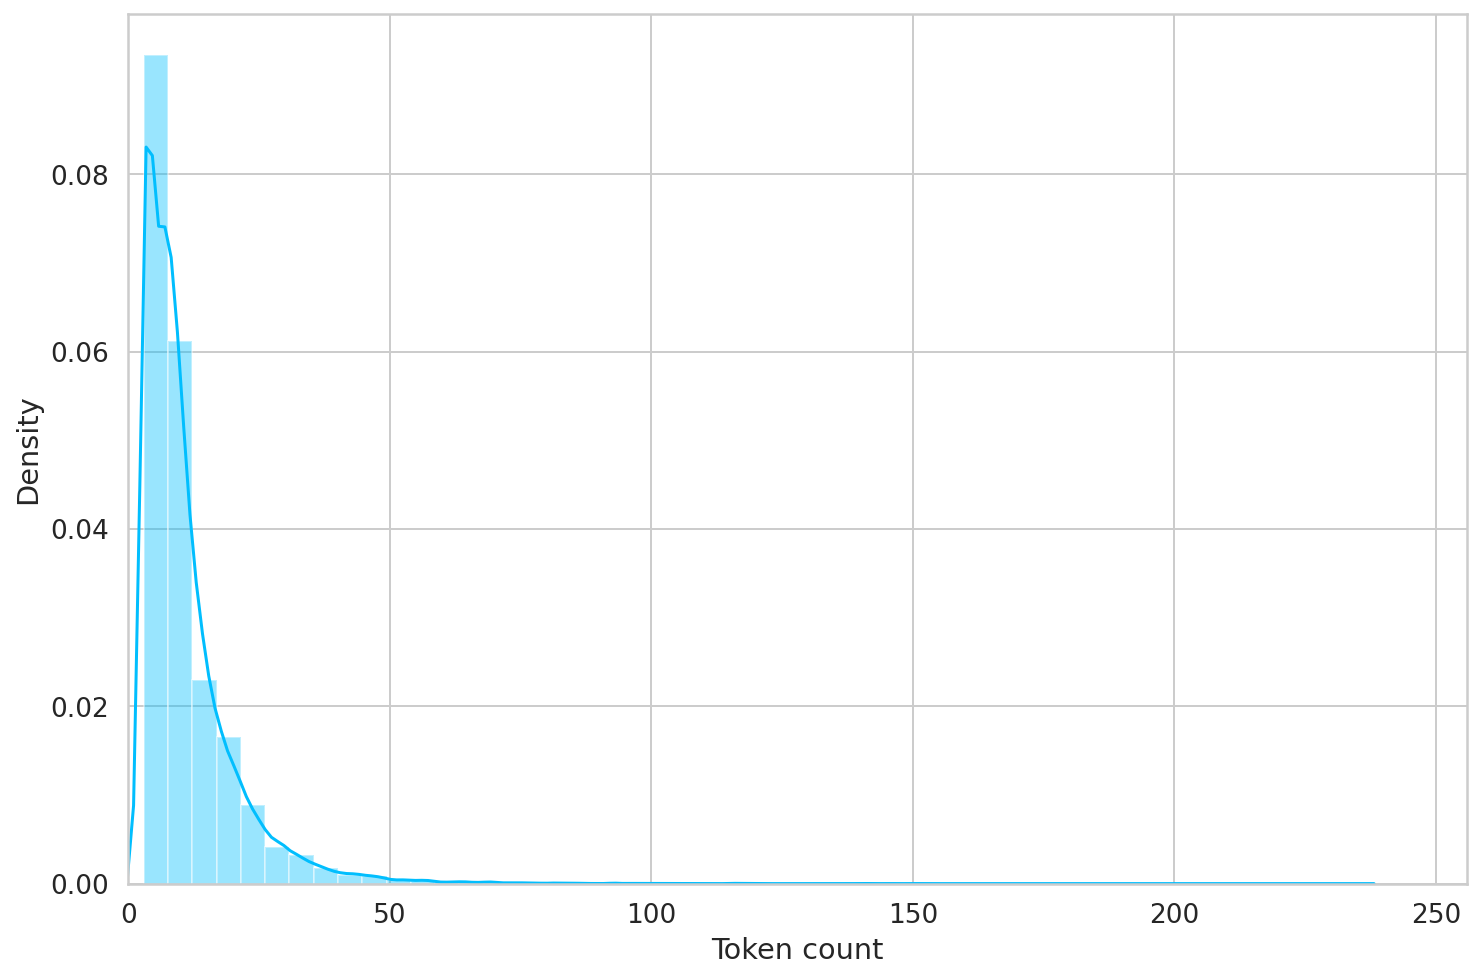

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
# Most of the utterances seem to contain less than 50 tokens.
MAX_LEN = 25

In [ ]:
# when feed data into the model, should do many things:
# batching, some inputs and outputs and all of these should be given batch by batch
# (not easy to code) so pytorch has dataset and dataloader class that should make
# life easier for you.

class MovieCorpusDataset(Dataset):
  # In pytorch, need init, len and get item for each class you make
  def __init__(self, lines, targets, tokenizer, max_len):
    self.lines = lines # data
    self.targets = targets # scores
    self.tokenizer = tokenizer # tokenizer that it should tokenize with
    self.max_len = max_len # max length of data
  
  def __len__(self):
    return len(self.lines)
  
  # In each step, like a list. For example, item 1000, get the getitem gets an item id
  # and should output the item you want to output
  def __getitem__(self, item):
    line = str(self.lines[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      line,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    # Should always output with a dictionary 
    return {
      'line': line,
      # flatten makes lists of lists into one list
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      # not just numbers but tensors
      # NOTE: Need torch tensors when code in pytorch
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
# created a dataset that contains all of the data
# should feed the dataset into a data loader to be used in our training

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MovieCorpusDataset(
    lines=df.text.to_numpy(),
    targets=df[category].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  # Dataloader class imported from pytorch 
  # It can do it parallel to give us batch by batch.
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
# Equalize values in the category for train (to prevent it from only picking the best one).
print("Before Equalize:")
print(df_train[category].value_counts())

min_count = min(df_train[category].value_counts())

neg = df_train[df_train[category] == 0][:min_count]
pos = df_train[df_train[category] == 1][:min_count]

df_train = pd.concat([neg, pos])
df_train = df_train.sample(frac=1).reset_index(drop=True) # shuffling

print("\nAfter Equalize:")
print(df_train[category].value_counts())

Before Equalize:
0    30454
1    20517
Name: TF, dtype: int64

After Equalize:
0    20517
1    20517
Name: TF, dtype: int64


In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# MBTI Classification with BERT and Hugging Face

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Inherited from this class so need init and forward
class MBTIClassifier(nn.Module):

  # Dense layer of 768 to 3
  def __init__(self, n_classes):
    super(MBTIClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3) # dropout because we don't want it to be overfitted
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  # A 3 layer dense NN - first layer should be class (self.firstlayer = dense, second = dense, third = dense).
  # In forward, then first dense - do function, get output and input to second dense and input to third dense.
  def forward(self, input_ids, attention_mask):
    # Use _ to say it is not important for us/when we don't want an output
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask, 
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = MBTIClassifier(2)
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Training

In [ ]:
EPOCHS = 10 # not a good number, maybe do it 20 or more than 20 times (e.g., >100 times).

# AdamW is Adam but with regularization 
# original BERT paper use this (trust that they tried multiple optimizers and found this is the best).
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
# number of data we have times the number of epochs

# function to help you do the epochs and training
# warmup - he asked what does learning rate warm up mean on stackoverflow 2 yrs ago lol
# learning rate from high amts
# better to not start with a specific learning rate but to increase little by little to go to the desired amt
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# In each epoch, what do we want to do?
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  # Convert the model into the training phase - when you want to evaluate your model, shouldn't use the dropout layer
  # dropout is when u do it for training model
  # need dropout layer for training model (so it doesn't overfit). But makes it worse when you use 
  # your model
  # training phase and eval phase does this 
  # when training phase - dropout will be active
  # when evaluating, dropout will not be active.
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    # Getting the maximum of the output.
    # What model predicted is the maximum probability so take the max probability.
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets) # loss fn which are cross entropy
    # 1 is 1 and the other ones are 0

    # sum up all the 1's - the number of correct predictions
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    # esp in RNN or LSTM when your gradients will explode (bad). 
    # clip large gradients so it won't explode and help your model so it won't
    # go into bad direction.
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# Same code as train but without optimizer steps (just want to get the predictions and see what is the loss).
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  # no gradient just makes it way faster because model does not need to calc the gradients
  # and speed is important - good for making it faster
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# To clean output of next cell so it's easier to read.
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%%time

# The time thing outputs a time for you in terms of how long it took
EPOCHS = 10 
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  # Save model whenever the accuracy is the maximum.
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.7158809239868997 accuracy 0.5010722815226398
Val   loss 0.7159236629803976 accuracy 0.2937722144954412

Epoch 2/10
----------
Train loss 0.6988203645914386 accuracy 0.5003655505190817
Val   loss 0.7378299118560038 accuracy 0.2937722144954412

Epoch 3/10
----------


KeyboardInterrupt: ignored

In [ ]:
train_acc = []
for tensor in history['train_acc']: 
  train_acc.append(tensor.cpu().detach().numpy())

val_acc = []
for tensor in history['val_acc']: 
  val_acc.append(tensor.cpu().detach().numpy())

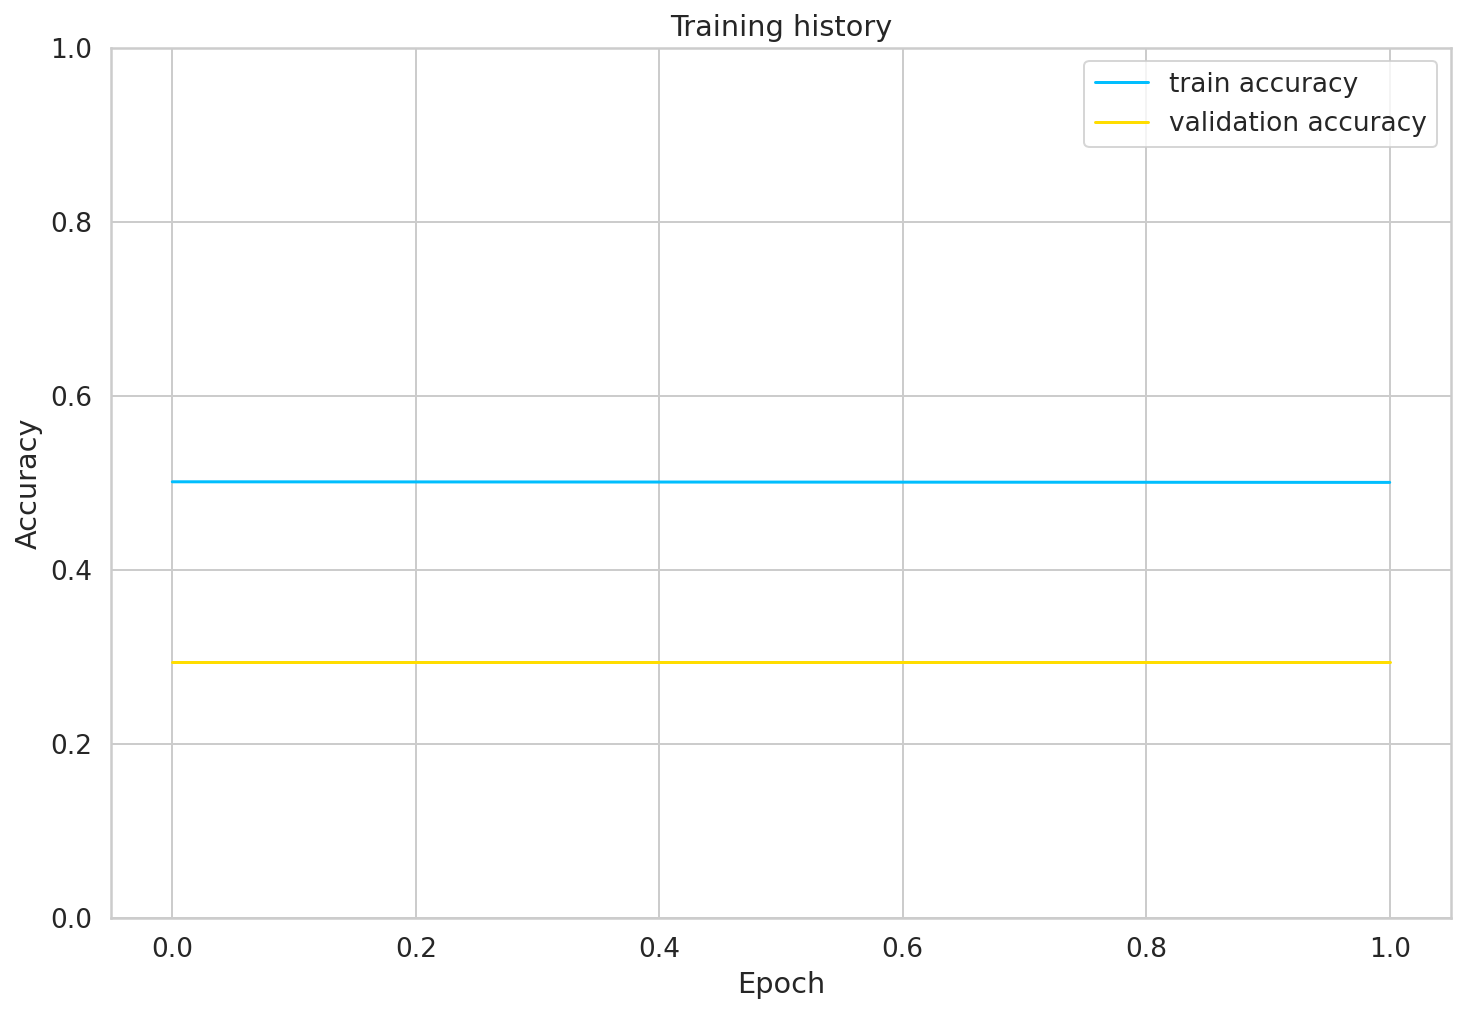

In [ ]:
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

#### Evaluation

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.5453365072495131

In [ ]:
def get_predictions(model, data_loader):
  # NOTE: Here, model.eval b/c we don't want to use dropout in eval section.
  model = model.eval()
  
  lines = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["line"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      lines.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return lines, predictions, prediction_probs, real_values

In [ ]:
y_lines_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      1.00      0.71      2520
           1       0.00      0.00      0.00      2101

    accuracy                           0.55      4621
   macro avg       0.27      0.50      0.35      4621
weighted avg       0.30      0.55      0.38      4621



In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("* Accuracy: %.2f%%" % (accuracy * 100.0))

* Accuracy: 54.53%


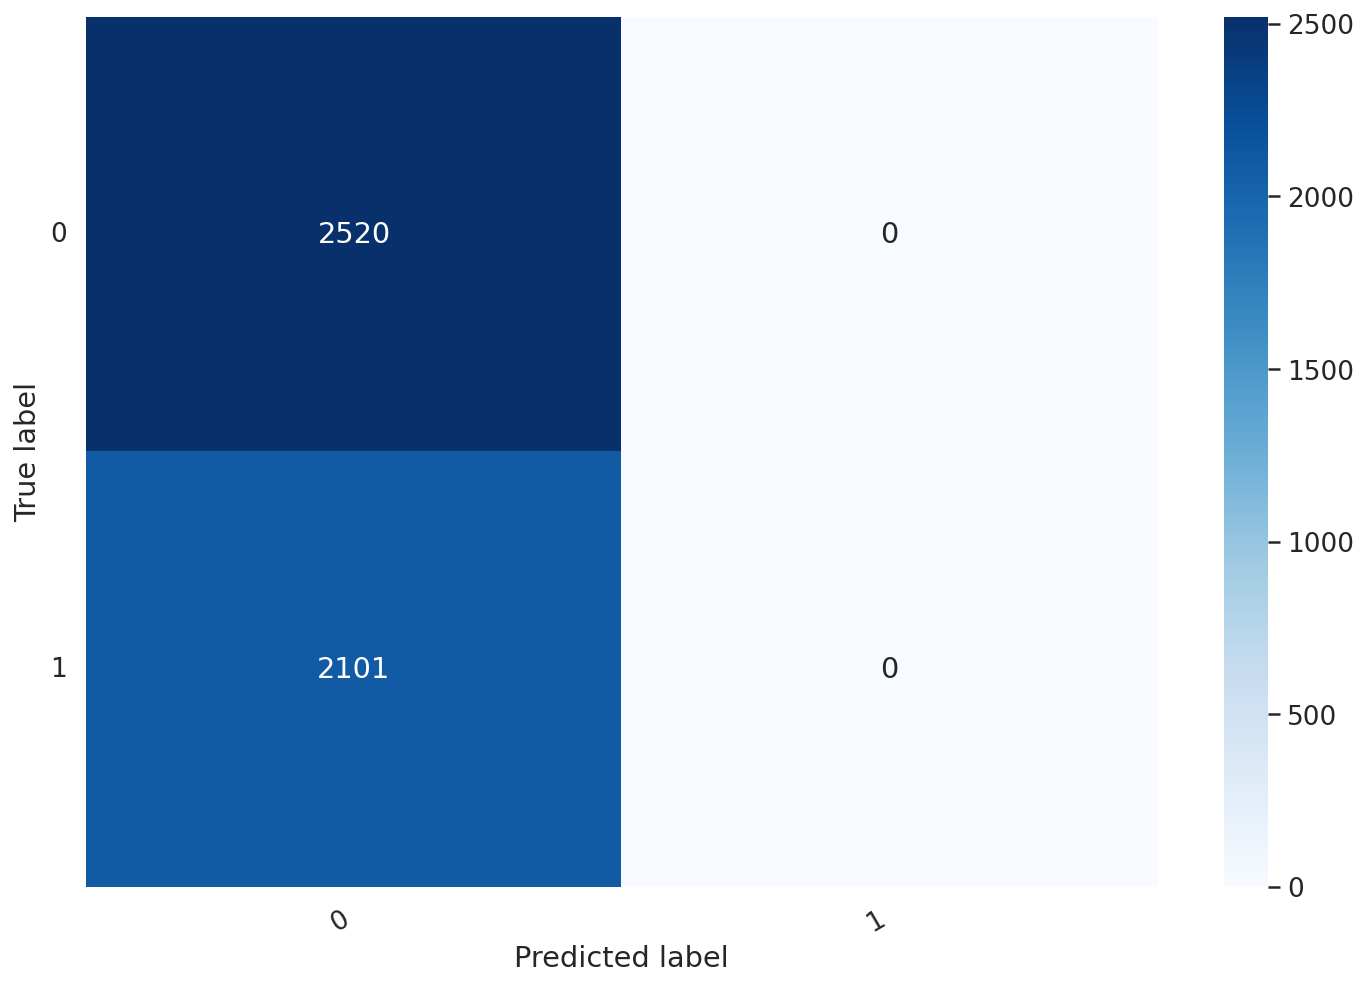

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True label')
  plt.xlabel('Predicted label');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

In [ ]:
df_results = df_test
df_results["TF_pred"] = y_pred

In [ ]:
df_results.to_csv(DATA_FILE_PATH+"/TF_pred.csv")